In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

In [2]:
from math import log

def eval_logloss(y, p):
    if len(y) == len(p):
        N = len(y)
    else:
        return
    
    logloss = 0
    for i in range(N):
        logloss = logloss - 1/N * (y[i] * log(p[i]) + (1-y[i]) * log(1-p[i]))
    
    return logloss

In [3]:
def create_logloss_list(y, p):
    loglosslist = []
    logloss = 0
    for i in range(len(y)):
        logloss = eval_logloss(y[:i], p[:i])
        loglosslist.append(logloss)
    
    return loglosslist

In [4]:
df = pd.read_csv('data/prep/2017season.csv')

In [5]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [6]:
print('Train: ', len(train), '\n'
      'Test: ', len(test))

Train:  1050 
Test:  259


In [7]:
train_labels = train['Winner']
test_labels = test['Winner']

In [8]:
features = ['Day_Num', 'Home_DaysPast', 'Visitor_DaysPast',
            'Home_TotalWins','Home_TotalLosses', 'Home_HomeWins', 'Home_HomeLosses', 'Home_Streak', 
            'Home_AvgSpread', 'Home_AvgPts', 'Home_GamesPlayed',  
            'Visitor_TotalWins', 'Visitor_TotalLosses', 'Visitor_VisitorWins', 'Visitor_VisitorLosses', 'Visitor_Streak', 
            'Visitor_AvgSpread', 'Visitor_AvgPts', 'Visitor_GamesPlayed']

In [9]:
train_features = train[features]
test_features = test[features]

In [65]:
clf = MLPClassifier(solver='lbfgs', activation='logistic', alpha=1e-5, hidden_layer_sizes=(7,2), random_state=1)

In [66]:
clf.fit(train_features, train_labels)

MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(7, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [67]:
train_predictions = clf.predict_proba(train_features)
test_predictions = clf.predict_proba(test_features)

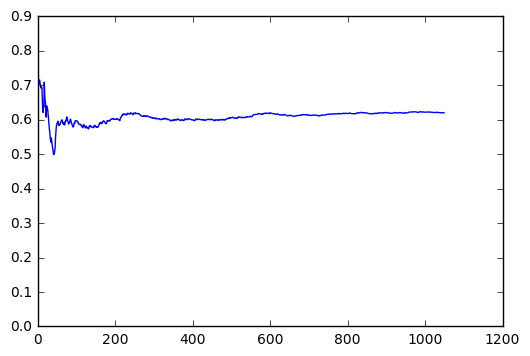

Final LogLoss value:  0.620137768295


In [68]:
fig = plt.figure()
fig.add_axes()

loglosslist = create_logloss_list(train_labels.tolist(), train_predictions[:,1].tolist())
ax1 = fig.add_subplot(111)
ax1.plot(range(len(loglosslist)), loglosslist)

plt.show()
print('Final LogLoss value: ', loglosslist[-1])

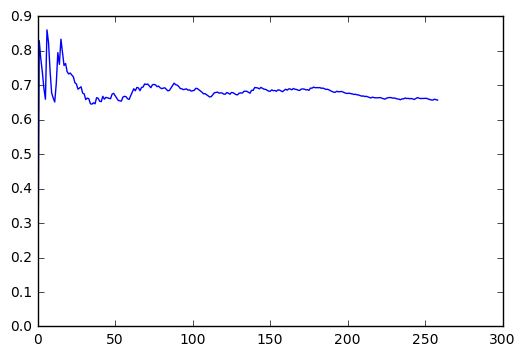

Final LogLoss value:  0.657098160994


In [69]:
fig = plt.figure()
fig.add_axes()

loglosslist = create_logloss_list(test_labels.tolist(), test_predictions[:,1].tolist())
ax1 = fig.add_subplot(111)
ax1.plot(range(len(loglosslist)), loglosslist)

plt.show()
print('Final LogLoss value: ', loglosslist[-1])